# Pandana network accessibility simple demo

This notebook uses [pandana](https://udst.github.io/pandana/network.html) (v0.2) to download street network and points-of-interest data from OpenStreetMap and then calculate network accessibility to the points of interest. Note: pandana currently only runs on Python 2.
  
For a more in-depth demo, check out [pandana-accessibility-demo-full.ipynb](pandana-accessibility-demo-full.ipynb)

In [3]:
import pandana, matplotlib.pyplot as plt
from pandana.loaders import osm
%matplotlib inline

In [4]:
bbox = [37.76, -122.35, 37.9, -122.17] #lat-long bounding box for berkeley/oakland
bbox =[43.5847,-79.6393 ,43.8554,-79.1156]#BBOX for toronto
amenity = 'pub' #accessibility to this type of amenity
distance = 1500 #max distance in meters

## Download points of interest (POIs) and network data from OpenStreetMap

In [5]:
# first download the points of interest corresponding to the specified amenity type
pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags='"amenity"="{}"'.format(amenity))
pois[['amenity', 'name', 'lat', 'lon']].tail()

,amenity,name,lat,lon
id,,,,
5445755322,pub,Betty's,43.651576,-79.367566
5473847122,pub,Dave's On St. Clair,43.681486,-79.427370
5478254822,pub,Loons Restaurant & Pub,43.651739,-79.451237
5506942792,pub,Craft Beer Market,43.650210,-79.378151
5646603333,pub,Firkin on Danforth,43.685370,-79.313373


In [7]:
# query the OSM API for the street network within the specified bounding box
network = osm.network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])

# how many network nodes did we get for this bounding box?


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](43.58470000,-79.63930000,43.85540000,-79.11560000);>;);out;'}"
Downloaded 75,632.7KB from www.overpass-api.de in 7.05 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 8.50 seconds
Returning OSM data with 474,892 nodes and 109,211 ways...
Edge node pairs completed. Took 137.60 seconds
Returning processed graph with 146,558 nodes and 220,458 edges...
Completed OSM data download and Pandana node and edge table creation in 159.81 seconds


2

In [14]:
network[0]
network[1]
network = pandana.Network(network[0]["x"], network[0]["y"], network[1]["from"], network[1]["to"],
                 network[1][["distance"]])

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\pandana\network.py:132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.as_matrix().astype('float32'),
C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\pandana\network.py:133: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix().astype('int32'),
C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\pandana\network.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges_df[edge_weights.columns].transpose()


## Process the network data then compute accessibility

In [15]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
# do nothing with this for now, but see full example in other notebook for more
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

In [6]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [16]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=1, max_dist=distance, max_pois=7)

In [20]:
# initialize a category for this amenity with the locations specified by the lon and lat columns
network.set_pois(category='my_amenity', x_col=pois['lon'], y_col=pois['lat'])

In [21]:
# search for the n nearest amenities to each node in the network
access = network.nearest_pois(distance=distance, category='my_amenity', num_pois=7)

# each df cell represents the network distance from the node to each of the n POIs
access.head()

,1,2,3,4,5,6,7
id,,,,,,,
1497897,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
1497902,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
1497983,471.903992,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
1497986,572.262024,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
1497993,346.700012,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


## Plot the accessibility

In [22]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


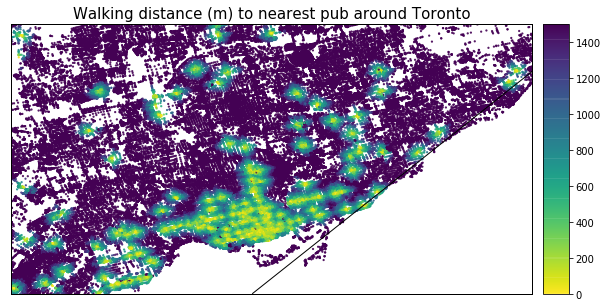

In [25]:
# plot the distance to the nth nearest amenity
n = 1
bmap, fig, ax = network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_title('Walking distance (m) to nearest {} around Toronto'.format(amenity), fontsize=15)
fig.savefig('./accessibility-pub-Toronto.png', dpi=600, bbox_inches='tight')
plt.show()

For a more in-depth demo, check out [pandana-accessibility-demo-full.ipynb](pandana-accessibility-demo-full.ipynb)